# Fitting a visual binary system using `isochrones`

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from isochrones import StarModel
from isochrones.dartmouth import Dartmouth_Isochrone

## 1. Setup

We want to build a `StarModel` object that has all the desired properties; the first step is to provide all the desired observational data.

This is the `star.ini` file used in Morton+ (2016) for this KOI.  This is the "classic" format for an `isochrones` `ini` file, with no information about any companions.

And this is what an `ini` file should look like with the new `isochrones` format, now incorporating info for observed companions.  Here, the "KIC" and "twomass" sections will be assumed to relate to the whole system (that is, the unresolved, blended fluxes of both stars).  "NIRC2" here will be assumed to be describing a companion; thus, delta-mags.  

In [2]:
%%file test_1874.ini

maxAV = 1.216
Teff = 4135, 98.0
feh = -0.46, 0.16
logg = 4.711, 0.1

#index = 0,1

[KIC]
g = 16.5832173, 0.05
r = 15.341168, 0.05
i = 14.917236, 0.05
z = 14.6382752, 0.05

[twomass]
J = 13.513, 0.02
H = 12.845, 0.02
K = 12.693, 0.02

[NIRC2]
resolution = 0.1
separation = 0.6
PA = 100
K = 3.66, 0.05
H = 3.77, 0.03
J = 3.74, 0.05

Overwriting test_1874.ini


## Create StarModel

OK here now we create a `StarModel` object from this `ini` file, and take a look at its `ObservationTree` object.  The leaves `0_0` and `0_1` refer to the model nodes whose stellar properties will be fit for.  The fact that they share a `0` in the first half of the label  means they are in the same physical system (and thus share `age`, `feh`, `distance`, `AV` in common).

The way this tree structure describes the model is that the flux in any "observational" node (indicated by the band, magnitude, position, etc.) comes from all model node leaves that are descended from it.  Thus, the "NIRC2" measurements each have only one contributing star, whereas the KIC and twomass measurements contain both stars.  The `StarModel` object should generate these trees automatically given the observational data provided, but it is a good idea to take a look at it like this to make sure that it is behaving as intended.

In [3]:
mod = StarModel.from_ini(Dartmouth_Isochrone, ini_file='test_1874.ini')
mod.obs.print_ascii()

root
 ╚═ KIC g=(16.58, 0.05) @(0.00, 0 [4.00])
    ╚═ KIC i=(14.92, 0.05) @(0.00, 0 [4.00])
       ╚═ KIC r=(15.34, 0.05) @(0.00, 0 [4.00])
          ╚═ KIC z=(14.64, 0.05) @(0.00, 0 [4.00])
             ╚═ twomass H=(12.85, 0.02) @(0.00, 0 [4.00])
                ╚═ twomass J=(13.51, 0.02) @(0.00, 0 [4.00])
                   ╚═ twomass K=(12.69, 0.02) @(0.00, 0 [4.00])
                      ╠═ NIRC2 delta-H=(0.00, 0.01) @(0.00, 0 [0.10])
                      ║  ╚═ NIRC2 delta-J=(0.00, 0.01) @(0.00, 0 [0.10])
                      ║     ╚═ NIRC2 delta-K=(0.00, 0.01) @(0.00, 0 [0.10])
                      ║        ╚═ 0_0, logg=[4.711, 0.1], Teff=[4135.0, 98.0], feh=[-0.46, 0.16]
                      ╚═ NIRC2 delta-H=(3.77, 0.03) @(0.60, 100 [0.10])
                         ╚═ NIRC2 delta-J=(3.74, 0.05) @(0.60, 100 [0.10])
                            ╚═ NIRC2 delta-K=(3.66, 0.05) @(0.60, 100 [0.10])
                               ╚═ 0_1


## Fit StarModel

Now, we run `fit_multinest` to find the posterior probability distribution of the model parameters.

In [4]:
mod.fit_multinest() #If this has already run, the results will be loaded quickly. 
                    # Otherwise, it will take ~5-10 minutes to run the fit.
                    # use refit=True if you want to re-run a fit.

OK, now we can explore the fit-- first, visualize the posteriors of the physical parameters of each star being modeled:

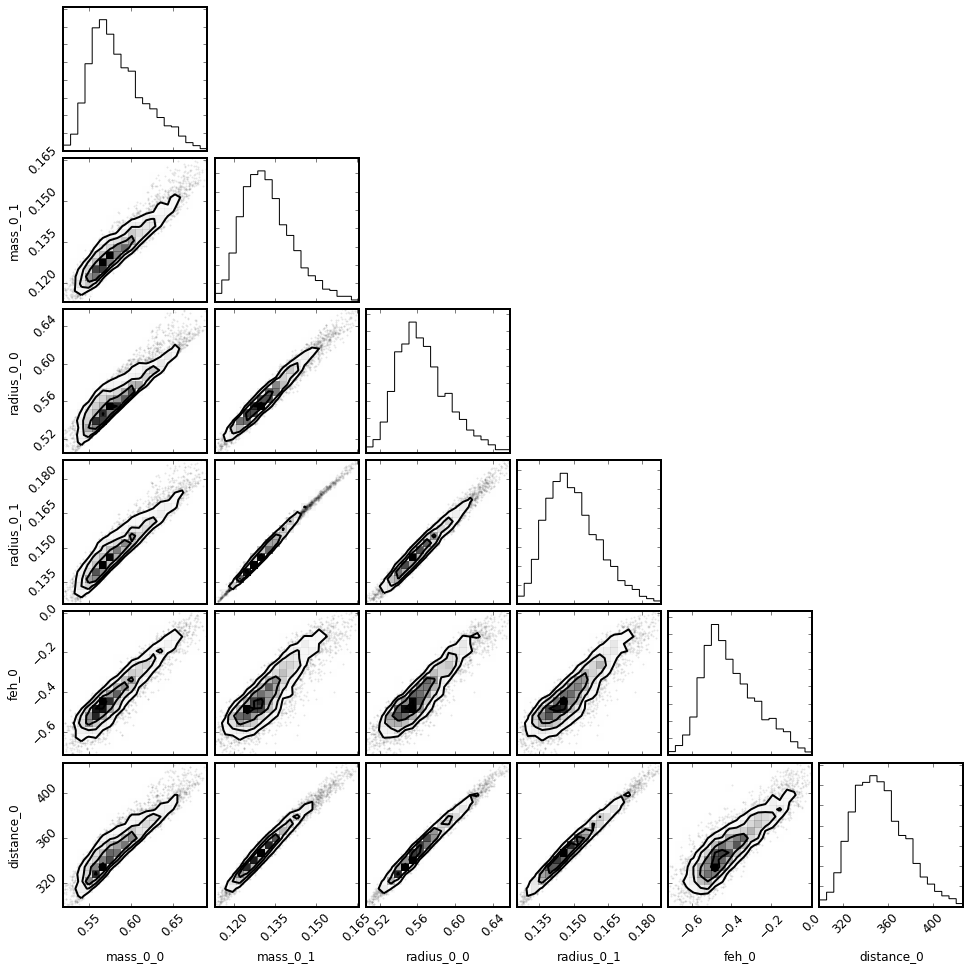

In [5]:
mod.corner_physical();

And this shows how each observation matches with the chains.  Note here now the 'relative' magnitudes are labeled as $\Delta$-mag.

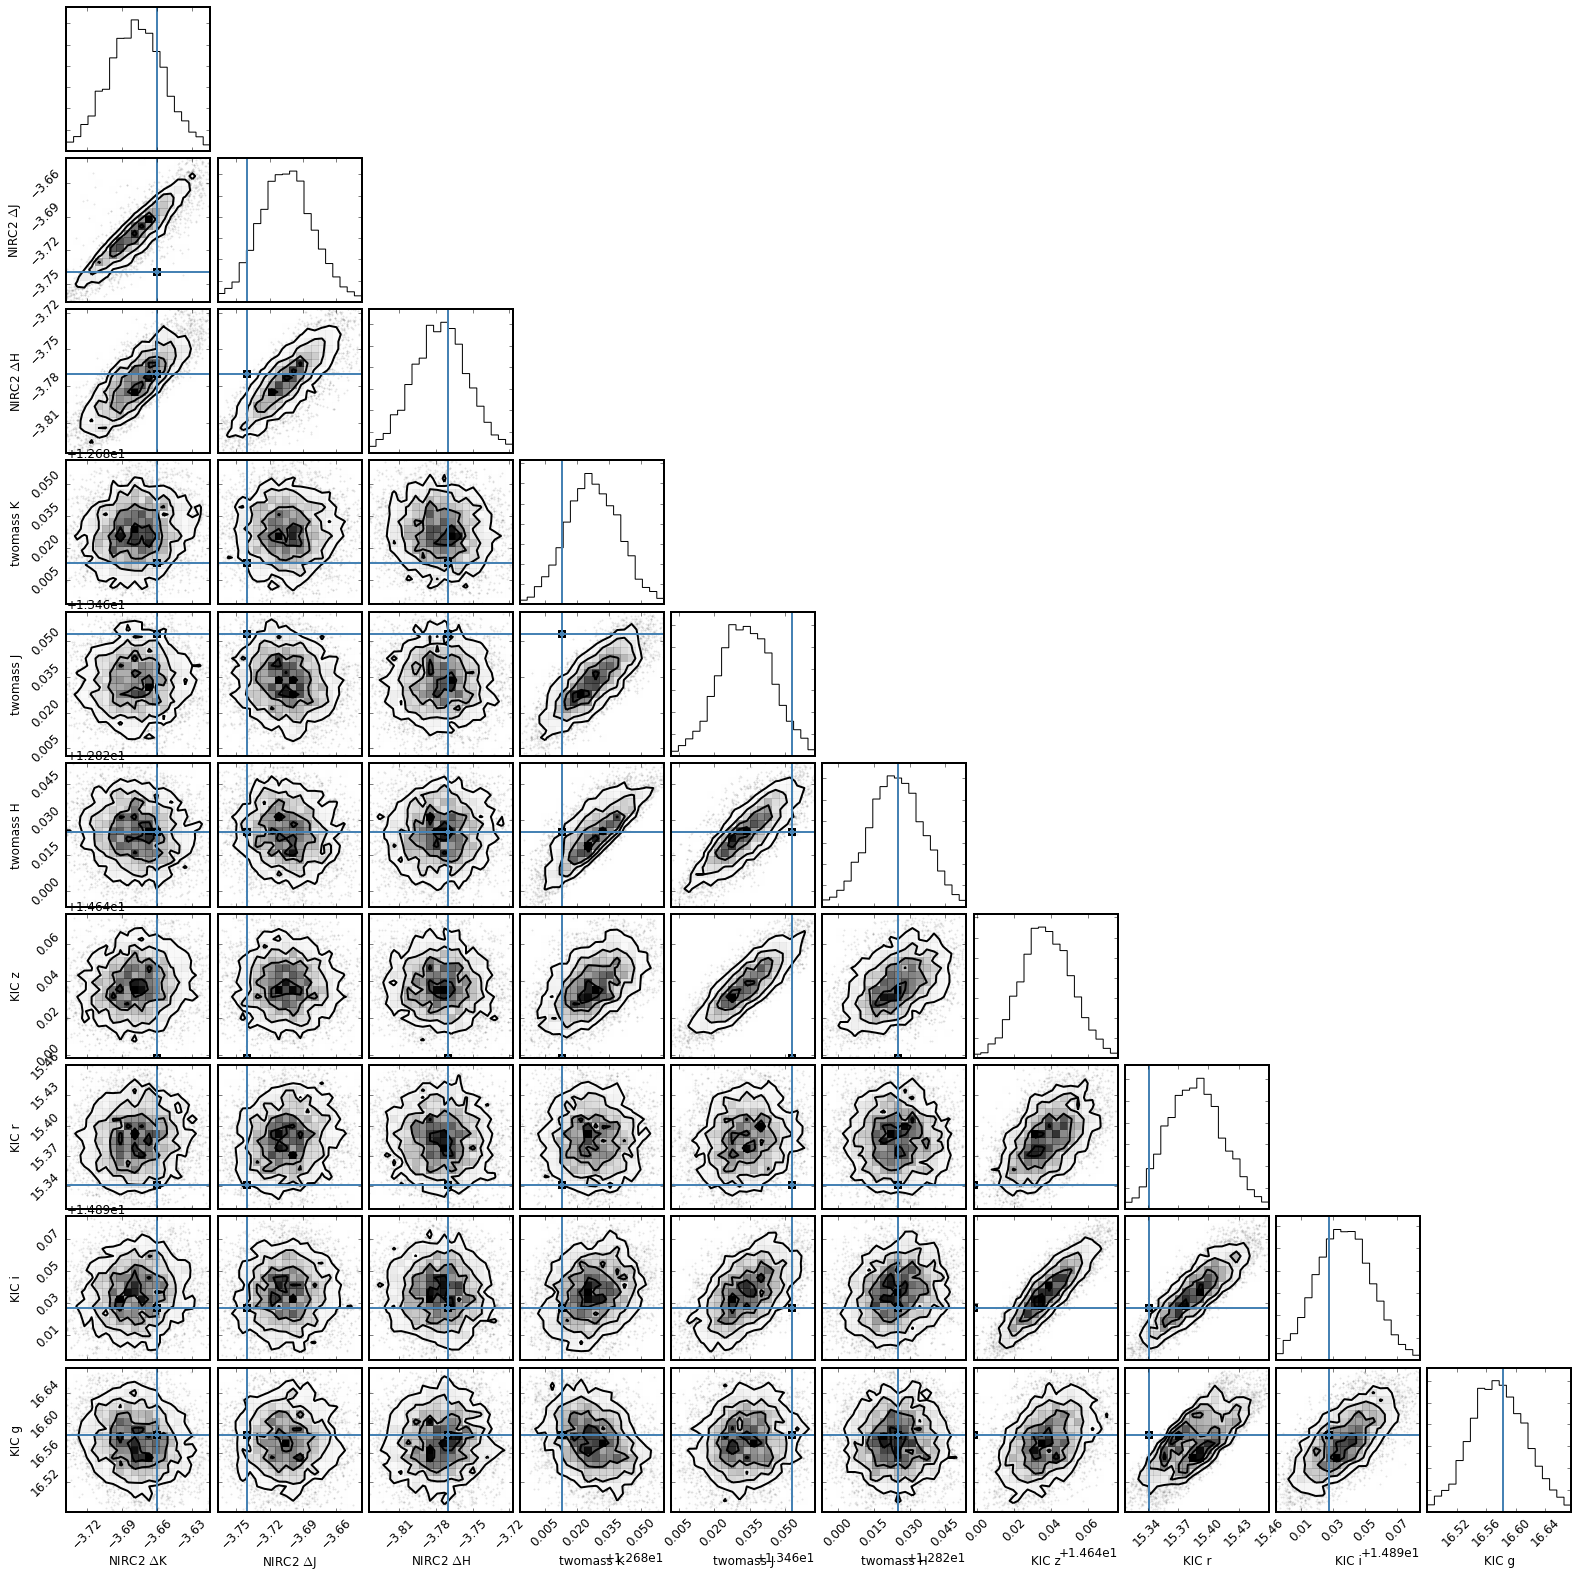

In [6]:
mod.corner_observed();

## Physically unassociated fit

Now we want to fit the same observation data, but set up the model a bit differently.  The only difference in the `ini` file below is that there is now an `index = 0,1`, which indicates that we want the two stars *not* to be physically associated.

Also, instead of putting all the observational data directly into the `ini` file, this time we use the `obsfile` keyword, which points to a CSV file containing a DataFrame of the observational information.  This is just to demonstrate another mode of setting up the data, rather than putting it all directly in the `ini` file as done above.  

In [7]:
# Just to see what this is:
mod.obs.to_df()

,band,e_mag,mag,name,pa,relative,resolution,separation
0,g,0.05,16.583217,KIC,0.0,False,4.0,0.0
1,i,0.05,14.917236,KIC,0.0,False,4.0,0.0
2,r,0.05,15.341168,KIC,0.0,False,4.0,0.0
3,z,0.05,14.638275,KIC,0.0,False,4.0,0.0
4,H,0.02,12.845000,twomass,0.0,False,4.0,0.0
5,J,0.02,13.513000,twomass,0.0,False,4.0,0.0
6,K,0.02,12.693000,twomass,0.0,False,4.0,0.0
7,H,0.01,0.000000,NIRC2,0.0,True,0.1,0.0
8,H,0.03,3.770000,NIRC2,100.0,True,0.1,0.6
9,J,0.01,0.000000,NIRC2,0.0,True,0.1,0.0


In [8]:
# Now, write this to a file that will be read by the ini
mod.obs.to_df().to_csv('test_1874_obs.csv')

In [9]:
%%file test_1874_2.ini

maxAV = 1.216
Teff = 4135, 98.0
feh = -0.46, 0.16
logg = 4.711, 0.1

index = 0,1

obsfile = test_1874_obs.csv

Overwriting test_1874_2.ini


OK, now the above tells the model to make unassociated model nodes; see the result below (model node labels of `0_0` and `1_0` instead of `0_0` and `0_1` as it was above):

In [10]:
mod2 = StarModel.from_ini(Dartmouth_Isochrone, ini_file='test_1874_2.ini')
mod2.obs.print_ascii()

root
 ╚═ KIC g=(16.58, 0.05) @(0.00, 0 [4.00])
    ╚═ KIC i=(14.92, 0.05) @(0.00, 0 [4.00])
       ╚═ KIC r=(15.34, 0.05) @(0.00, 0 [4.00])
          ╚═ KIC z=(14.64, 0.05) @(0.00, 0 [4.00])
             ╚═ twomass H=(12.85, 0.02) @(0.00, 0 [4.00])
                ╚═ twomass J=(13.51, 0.02) @(0.00, 0 [4.00])
                   ╚═ twomass K=(12.69, 0.02) @(0.00, 0 [4.00])
                      ╠═ NIRC2 delta-H=(0.00, 0.01) @(0.00, 0 [0.10])
                      ║  ╚═ NIRC2 delta-J=(0.00, 0.01) @(0.00, 0 [0.10])
                      ║     ╚═ NIRC2 delta-K=(0.00, 0.01) @(0.00, 0 [0.10])
                      ║        ╚═ 0_0, logg=[4.711, 0.1], Teff=[4135.0, 98.0], feh=[-0.46, 0.16]
                      ╚═ NIRC2 delta-H=(3.77, 0.03) @(0.60, 100 [0.10])
                         ╚═ NIRC2 delta-J=(3.74, 0.05) @(0.60, 100 [0.10])
                            ╚═ NIRC2 delta-K=(3.66, 0.05) @(0.60, 100 [0.10])
                               ╚═ 1_0


And now we fit this model, this time giving a different basename to multinest, so it stores the output files distinctly from the default (that was used above).

In [11]:
mod2.fit_multinest(basename='unassoc')

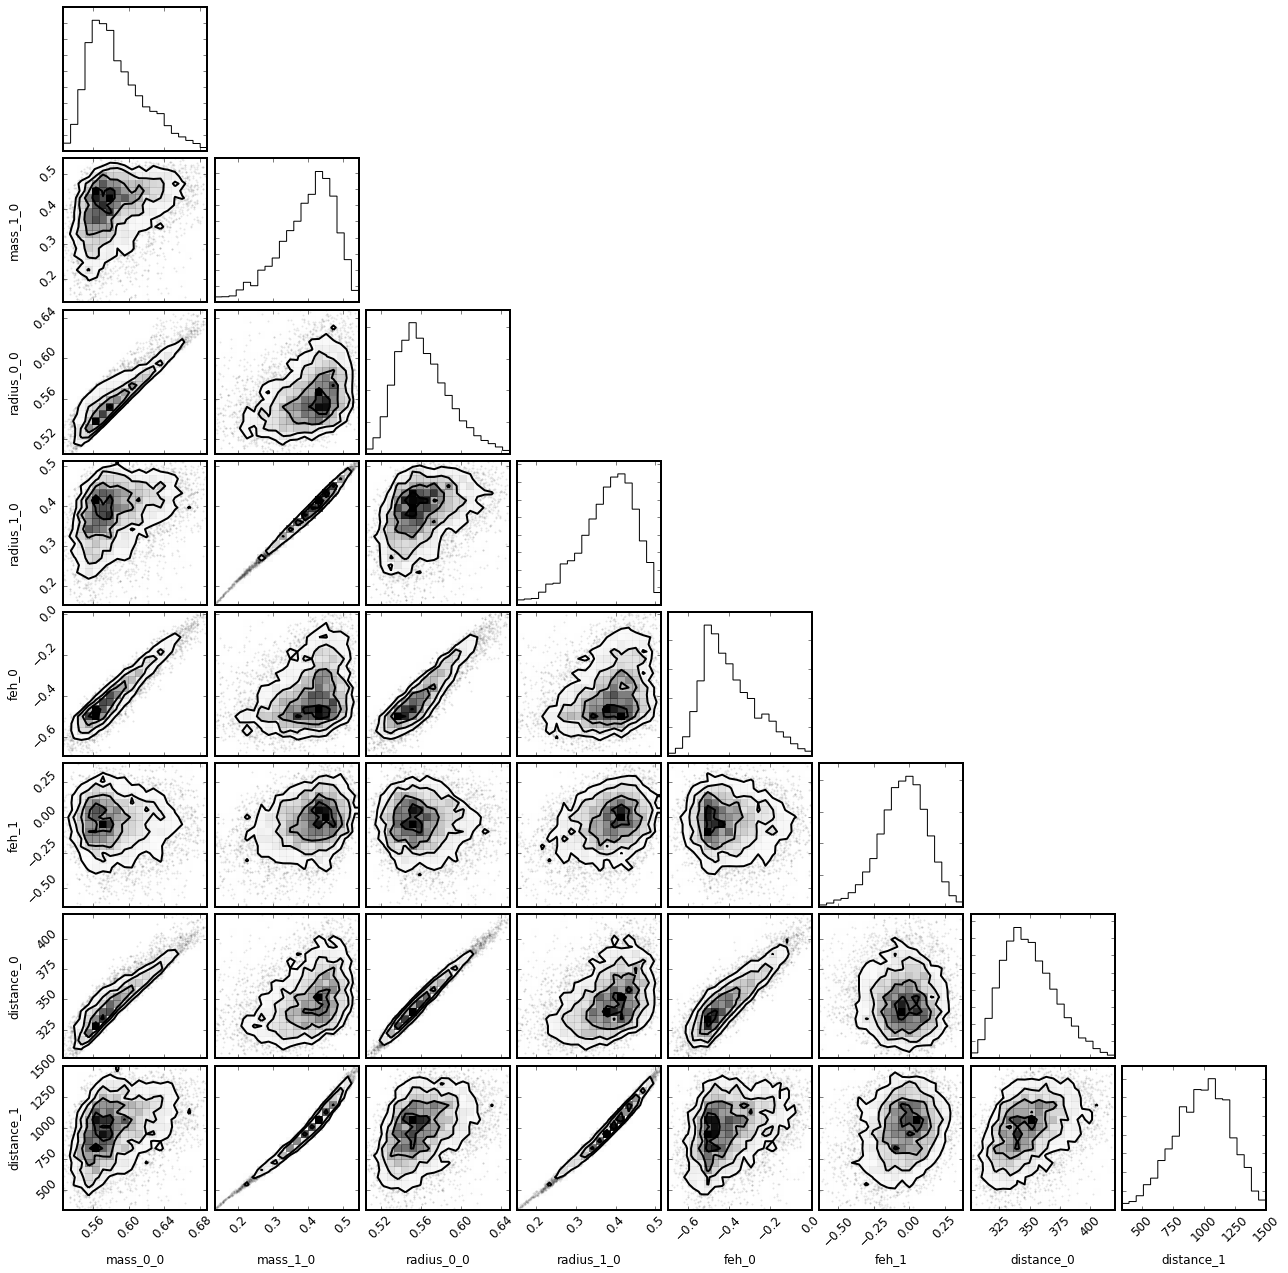

In [12]:
mod2.corner_physical();

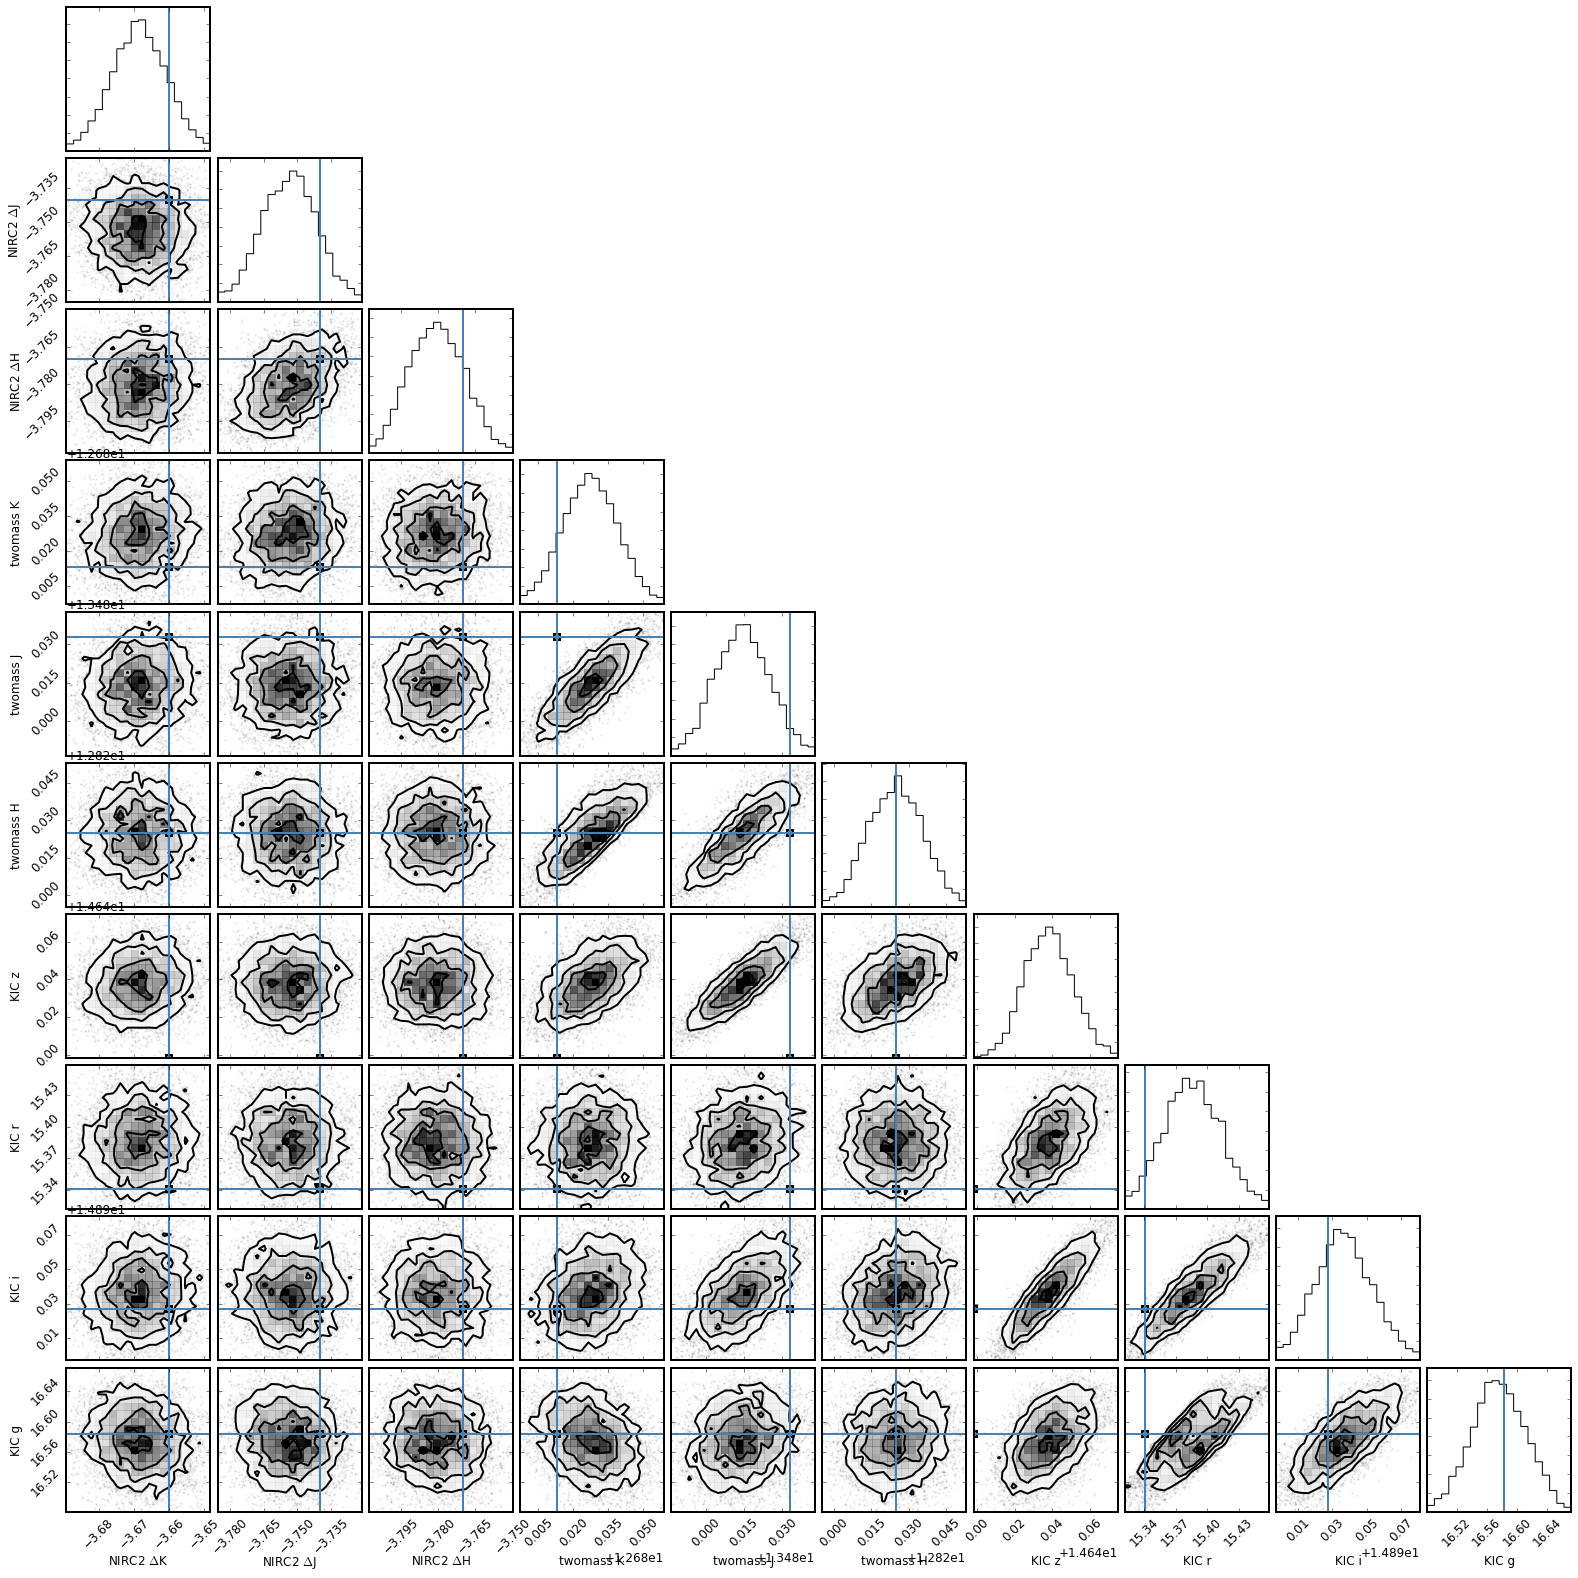

In [13]:
mod2.corner_observed();

We can look at the log-evidence of both of these models; from this it appears that the associated model is preferred. 

In [14]:
mod.evidence

  analysing data from chains/binary.txt


(-40.49131192739281, 0.09851271767521413)

In [15]:
mod2.evidence

  analysing data from chains/unassoc.txt


(-54.37236104399032, 0.05714821527994301)